<a href="https://colab.research.google.com/github/andysingal/nlp/blob/main/consumer_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
#!ssh-keygen -t rsa -b 4096

In [162]:
#!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

In [163]:
#!cat /root/.ssh/id_rsa.pub

In [164]:
#!pip install git+ssh://git@github.com/andysingal/preprocess_andy.git

In [165]:
#!python -m textblob.download_corpora

In [166]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [167]:
!pip install h2o

In [168]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import preprocess_andy as ps

In [169]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 7 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_zamtcz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.092 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [170]:
df=pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true', compression='zip', sep=',', quotechar='"')

In [171]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter 

In [172]:

df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                       9799 
Checking or savings account    7003 
Student loan                   2950 
Vehicle loan or lease          2736 
Name: Product, dtype: int64

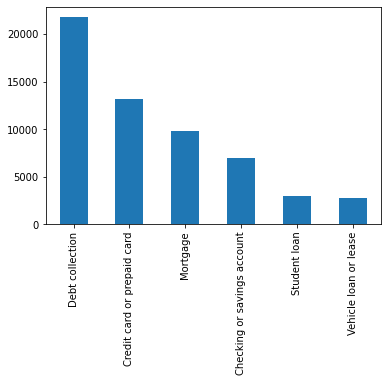

In [173]:
df['Product'].value_counts().plot(kind='bar')

In [174]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
Buckles & Buckles, P.L.C.                1   
Federated Student Loan Services          1   
Morgan & Associates, P.C.                1   
AMERICAN PORTIFOLIO MORTGAGE             1   
SEMPER HOME LOANS, INC                   1   
Name: Company, Length: 2197, dtype: int64

In [175]:
complaints_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})

In [176]:
pd.set_option('display.max_colwidth', -1)
complaints_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

Text(0.5, 1.0, 'Ratio of missing values per columns')

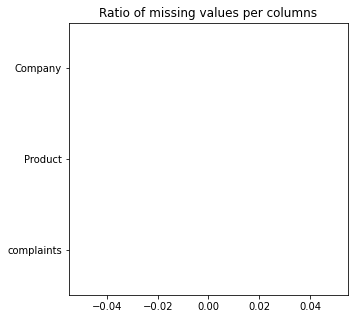

In [177]:
plt.figure(figsize=(5, 5))
complaints_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [178]:
target={'Debt collection':0, 'Credit card or prepaid card':1, 'Mortgage':2, 'Checking or savings account':3, 'Student loan':4, 'Vehicle loan or lease':5}

In [179]:
complaints_df['target']=complaints_df['Product'].map(target)

In [180]:
complaints_df

,complaints,Product,Company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

In [181]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.get_cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    
    return x

In [182]:
complaints_df['complaints'] = complaints_df['complaints'].apply(lambda x :get_clean(x))

In [183]:
complaints_df

,complaints,Product,Company,target
0,this auto loan was opened on x2020 in x nc with bb t in my name i have never been to north carolina and i have never been a resident i have filed a thispute twice through my credit bureaus but both times bb t has claimed that this is an accurate loan which i was not aware of until today i have tried to contact bb t multiple times but i have never gotten through to a live person i do nt drive and i have never owned a car before i did not have any knowledge of this account until i checked x x and noticed it i have tried twice to thispute it additionally i never received any bills or information about this account this is my last resort in trying to remove this fraudulent loan off of my account,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,in x of 2019 i noticed a debt for 620 on my credit which i believed was mine i thought speedy cash had bought one of my old debts and sold it to x x x x i contacted x x x x and after several attempts of giving my full name nothing came up in their system i gave my social and the rep said the account popped up but did not tell me that the account was under someone elses name and continued to let me make a payment the payment was for 120 confirmation numberx after realizing it was not my account i called back to get my money back and inform them of the mistake i was told i needed to mail them an ftc report and thispute letter to get my money back i completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and i would need to contact them after contacting them i was again told that i can not get my money back the issue im having is this representative at x x played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back,Debt collection,CURO Intermediate Holdings,0
2,as stated from capital one x x and x 2018 my wife and i went to several car dealerships to request for a car loan to get a used car however according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time it seemed as though they pulled my credit report multiple times,Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,please see cfpb case x capital one in the letter they provided and attached to that case as their response said this the funds were reversed and sent back to x x x on x x x x now x x has not received these funds staff at x x and also staff at the accountholder s business have looked for return of my money 650 and find nothing capital one needs to document actually prove they returned the funds as stated in their letter capital one must provide electronic information if the return was made that way or document the paper check they sent back to x x i have left 3 messages about this problem for the person who signed the letter x from capital one i have received no callbacks summary capital one said they returned my money on x they did not if they continue claim they did then they need to prove that,Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,this debt was incurred due to medical malpractice x x x x tx i asked the doctor to turn over my claim to his malpractice insurance company this has cost me thousands of dollars to x x x i am still trying to collect damages from this doctor he never responded and turned over me to collections merchants and professional collection bureau inc i sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies they never verified the debt like i asked and they never stopped it from being reported when i specifically told them not to due to the circumstances above,Debt collection,"Merchants and Professional Bureau, Inc.",0
...,...,...,...,...
57448,i am attempting to make a payment toward my student loans on the nelnet website today x20 and

In [184]:
X_train, X_test = train_test_split(complaints_df, test_size=0.2, random_state=111)

In [185]:
#stemmer = PorterStemmer()
stemmer = nltk.stem.SnowballStemmer('english')

In [186]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [187]:
def tokenize(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   tokens = map(str.lower, tokens)
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

In [188]:
#complaints_df['complaints_tok']=complaints_df['complaints'].apply(lambda x: tokenize(x))

In [189]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.complaints)

In [190]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05981037, 0.        , ..., 0.        , 0.        ,
        0.04798812],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09585797],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [191]:
#vectorizer_tf.get_feature_names()

In [192]:
test_vectors = vectorizer_tf.transform(X_test.complaints)

In [193]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)], axis=1)
train_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,...,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,wouldnt,write,written,wrong,wrote,year,target
0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.012894,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029656,0.0,0.0,0.000000,0.026740,0.025400,0.0,0.0,0.000000,0.0,0.000000,0.029255,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.29131,0.362343,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
1,0.0,0.05981,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.075662,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047988,0
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.031241,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.021596,0.041028,0.0,0.0,0.032773,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.066089,0.0,0.0,0.046691,0.0,0.0,0.0,0.02508,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.02184,0.000000,0.00000,0.0,0.000000,0.026068,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.127644,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.32042,0.478262,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.056779,0.0,0.0,0.000000,0.0,0.184093,0.065397,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.06045,0.080112,0.00000,0.0,0.000000,0.108226,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
45958,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.103435,0.0,0.166521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.102653,0.165426,0.00000,0.000000,0.000000

In [194]:
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)], axis=1)
test_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,...,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,wouldnt,write,written,wrong,wrote,year,target
0,0.0,0.086977,0.0,0.0,0.0,0.212057,0.0,0.0,0.348415,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.045159,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.043223,0.0,0.000000,0.000000,0.085798,0.000000,0.000000,0.0,0.0,0.078447,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.109019,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.124632,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,2
2,0.0,0.141016,0.0,0.0,0.0,0.000000,0.0,0.0,0.211832,0.0,0.0,0.000000,0.0,0.187359,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.229033,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.208743,0.0,0.0,0.0,0.0,0.000000,1
3,0.0,0.088467,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.033502,0.0,0.0,0.043704,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.058178,0.000000,0.044706,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.036962,0.0,0.0,0.000000,0.045226,0.0,0.000000,0.0,0.0,0.0,0.0,0.070980,4
4,0.0,0.079903,0.0,0.0,0.0,0.000000,0.0,0.0,0.040010,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.118420,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.128219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.020169,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.098531,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.062845,0.0,0.0,0.0,0.000000,0.000000,0.048573,0.040033,0.0,0.113916,0.000000,0.039733,0.000000,0.000000,0.0,0.0,0.000000,0.058945,0.000000,0.0,0.038536,0.0,0.184113,0.100973,0.0,0.0,0.126817,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.032317,1
11487,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,

Convert Pandas Frame to H2O dataframe

In [195]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [196]:
#h2o_train_df.types

I am using hf[[x1, x2]] = hf[[x1, x2]].asfactor() to transform X1 and X2 to categorical variables and then train a classification model with automl(). 

In [197]:
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

In [198]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)

In [199]:
x=vectorizer_tf.get_feature_names()
y='target'

In [200]:
aml.train(x = x, y = y, training_frame = h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
07:51:04.854: Project: AutoML_20210606_75104854
07:51:04.854: Cross-validation disabled by user: no fold column nor nfolds > 1.
07:51:04.865: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
07:51:04.865: Build control seed: 10
07:51:04.865: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
07:51:08.392: training frame: Frame key: automl_training_py_383_sid_ae73    cols: 1001    rows: 41255  chunks: 53    size: 34432543  checksum: 5640034944337497142
07:51:08.395: validation frame: Frame key: py_384_sid_ae73    cols: 1001    rows: 11491  chunks: 14    size: 9657367  checksum: -3515057418145784608
07:51:08.788: leaderboard frame: Frame key: automl_leaderboard_py_383_sid_ae73    cols: 1001    rows: 4707  chunks: 53    size: 7467203  checksum: 7800989123050374800
07:51:08.788: blending frame: NULL
07:51:08.788: resp

In [201]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
GBM_2_AutoML_20210606_075104,0.150833,0.378543,0.331204,0.109696,nan,nan
GBM_3_AutoML_20210606_075104,0.154356,0.379981,0.333943,0.111518,nan,nan
XGBoost_1_AutoML_20210606_075104,0.154634,0.336255,0.311153,0.0968162,nan,nan
XGBoost_2_AutoML_20210606_075104,0.155568,0.331763,0.310031,0.0961191,nan,nan
GBM_4_AutoML_20210606_075104,0.157308,0.388812,0.335268,0.112405,nan,nan
XGBoost_3_AutoML_20210606_075104,0.157549,0.336271,0.31625,0.100014,nan,nan
GBM_5_AutoML_20210606_075104,0.159103,0.370918,0.329351,0.108472,nan,nan
GBM_1_AutoML_20210606_075104,0.167659,0.402872,0.346884,0.120328,nan,nan
GLM_1_AutoML_20210606_075104,0.178432,0.38053,0.338549,0.114615,nan,nan
DRF_1_AutoML_20210606_075104,0.292843,0.602915,0.448024,0.200725,nan,nan


In [202]:
pred=aml.leader.predict(h2o_test_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [203]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.11413475687441027
RMSE: 0.337838359092644
LogLoss: 0.3928550536164047
Mean Per-Class Error: 0.1628693194223928
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3859.0,181.0,78.0,39.0,58.0,80.0,0.101513,"436 / 4,295"
1,196.0,2215.0,19.0,117.0,4.0,32.0,0.142470,"368 / 2,583"
2,88.0,32.0,1813.0,27.0,18.0,37.0,0.100248,"202 / 2,015"
3,62.0,113.0,17.0,1260.0,0.0,9.0,0.137577,"201 / 1,461"
4,54.0,18.0,13.0,4.0,493.0,29.0,0.193126,118 / 611
5,93.0,35.0,17.0,7.0,7.0,367.0,0.302281,159 / 526
6,4352.0,2594.0,1957.0,1454.0,580.0,554.0,0.129145,"1,484 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.870855
1,2,0.953355
2,3,0.978766
3,4,0.990775
4,5,0.996954
5,6,1.000000


In [206]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [207]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20210606_075104


Model Summary: 


,,number_of_trees
0,,105.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.030123899584790944
RMSE: 0.17356237952042183
LogLoss: 0.11309425615316636
Mean Per-Class Error: 0.03626663826389858
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,15464.0,146.0,38.0,29.0,18.0,20.0,0.015972,"251 / 15,715"
1,210.0,9249.0,12.0,53.0,6.0,8.0,0.030300,"289 / 9,538"
2,63.0,42.0,6884.0,11.0,4.0,3.0,0.017554,"123 / 7,007"
3,56.0,59.0,5.0,4798.0,0.0,2.0,0.024797,"122 / 4,920"
4,50.0,39.0,6.0,0.0,1990.0,1.0,0.046021,"96 / 2,086"
5,92.0,54.0,8.0,5.0,6.0,1824.0,0.082956,"165 / 1,989"
6,15935.0,9589.0,6953.0,4896.0,2024.0,1858.0,0.025355,"1,046 / 41,255"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.974646
1,2,0.993746
2,3,0.997915
3,4,0.999515
4,5,0.999903
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09556443121787024
RMSE: 0.30913497249238925
LogLoss: 0.33141338724093794
Mean Per-Class Error: 0.15628737365006717
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,4002.0,136.0,48.0,25.0,43.0,41.0,0.068219,"293 / 4,295"
1,165.0,2284.0,21.0,98.0,2.0,13.0,0.115757,"299 / 2,583"
2,66.0,28.0,1864.0,18.0,11.0,28.0,0.074938,"151 / 2,015"
3,47.0,136.0,18.0,1255.0,0.0,5.0,0.140999,"206 / 1,461"
4,59.0,20.0,23.0,2.0,488.0,19.0,0.201309,123 / 611
5,86.0,40.0,36.0,8.0,7.0,349.0,0.336502,177 / 526
6,4425.0,2644.0,2010.0,1406.0,551.0,455.0,0.108694,"1,249 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.891306
1,2,0.964320
2,3,0.986685
3,4,0.993821
4,5,0.998173
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-06-06 07:51:08,0.018 sec,0.0,0.833333,1.791759,0.830154,NaN,NaN,0.833333,1.791759,0.824645,NaN,NaN
1,,2021-06-06 07:51:35,26.995 sec,5.0,0.456405,0.628264,0.121052,NaN,NaN,0.476896,0.677633,0.150292,NaN,NaN
2,,2021-06-06 07:51:54,46.021 sec,10.0,0.349113,0.401669,0.101733,NaN,NaN,0.386326,0.478970,0.137064,NaN,NaN
3,,2021-06-06 07:52:14,1 min 5.263 sec,15.0,0.309199,0.317719,0.088959,NaN,NaN,0.357634,0.413969,0.130711,NaN,NaN
4,,2021-06-06 07:52:37,1 min 28.246 sec,20.0,0.286448,0.273885,0.079602,NaN,NaN,0.343316,0.384583,0.124532,NaN,NaN
5,,2021-06-06 07:52:56,1 min 47.933 sec,25.0,0.270297,0.245283,0.070561,NaN,NaN,0.334941,0.368372,0.121660,NaN,NaN
6,,2021-06-06 07:53:15,2 min 6.978 sec,30.0,0.258092,0.224742,0.065277,NaN,NaN,0.329840,0.358911,0.119485,NaN,NaN
7,,2021-06-06 07:53:36,2 min 27.262 sec,35.0,0.248637,0.209693,0.060187,NaN,NaN,0.326285,0.353076,0.118266,NaN,NaN
8,,2021-06-06 07:53:56,2 min 47.943 sec,40.0,0.239941,0.196573,0.055872,NaN,NaN,0.323118,0.347723,0.116439,NaN,NaN
9,,2021-06-06 07:54:17,3 min 8.415 sec,45.0,0.232493,0.185661,0.052430,NaN,NaN,0.320756,0.344264,0.114785,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,debt,14372.413086,1.000000,0.094557
1,loan,11125.393555,0.774080,0.073194
2,card,10700.509766,0.744517,0.070399
3,mortgag,9944.752930,0.691933,0.065427
4,collect,7187.329590,0.500078,0.047286
5,bank,6047.166504,0.420748,0.039784
6,credit card,4832.707031,0.336249,0.031795
7,student,4651.383789,0.323633,0.030602
8,payment,3601.145264,0.250560,0.023692
9,deposit,3348.399414,0.232974,0.022029



See the whole table with table.as_data_frame()


In [208]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_delta_step': 0.0,
  'max_depth': 10,
  'min_child_weight': 5.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 6,
  'objective': 'multi:softprob',
  'seed': 10,
  'silent': True,
  'subsample': 0.6,
  'tree_method': 'exact'},
 10000)

In [209]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [212]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{'tree_method': 'exact'})

In [213]:
xgb_clf.fit(train_vectors, X_train['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='exact', verbosity=1)

In [214]:
predictions = xgb_clf.predict(test_vectors)

In [215]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3940  158   63   37   44   53]
 [ 273 2183   14   99    1   13]
 [  93   38 1825   25    6   28]
 [  89  128   21 1215    0    8]
 [  76   24   30    3  456   22]
 [ 112   56   32    8    3  315]]


In [216]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4295
           1       0.84      0.85      0.84      2583
           2       0.92      0.91      0.91      2015
           3       0.88      0.83      0.85      1461
           4       0.89      0.75      0.81       611
           5       0.72      0.60      0.65       526

    accuracy                           0.86     11491
   macro avg       0.85      0.81      0.83     11491
weighted avg       0.86      0.86      0.86     11491



In [217]:

from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(X_train['target']),
                                             X_train['target']))

In [218]:
class_weights

[0.43830939711239536,
 0.7219918316054037,
 0.9841127098321343,
 1.382232647660291,
 3.275046316089497,
 3.466214177978884]

In [219]:
weights = np.ones(X_train.shape[0], dtype = 'float')

In [220]:
for i, val in enumerate(X_train['target']):
    weights[i] = class_weights[val]

In [221]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{'tree_method': 'exact'})

In [222]:
xgb_clf.fit(train_vectors, X_train['target'], sample_weight=weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='exact', verbosity=1)

In [223]:
predictions = xgb_clf.predict(test_vectors)

In [224]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3654  189   77  108   87  180]
 [ 170 2104   18  179    3  109]
 [  41   21 1783   30   56   84]
 [  33   92   16 1291    5   24]
 [  23    6    4    2  518   58]
 [  50   20   10   12   23  411]]


In [225]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      4295
           1       0.87      0.81      0.84      2583
           2       0.93      0.88      0.91      2015
           3       0.80      0.88      0.84      1461
           4       0.75      0.85      0.80       611
           5       0.47      0.78      0.59       526

    accuracy                           0.85     11491
   macro avg       0.79      0.84      0.81     11491
weighted avg       0.86      0.85      0.85     11491

